# Практика

In [54]:
import numpy as np

class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.W = np.random.randn(input_size, output_size)*0.01
        self.b = np.zeros(output_size)

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        return X.dot(self.W)+self.b

    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - learning_rate*dLdw
        '''
        self.W = self.W - learning_rate * self.dLdW
        self.b = self.b - learning_rate * self.dLdb

class Sigmoid:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = 1./(1+np.exp(-X))
        return self.s

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return self.s*(1-self.s)*dLdy

    def step(self, learning_rate):
        pass

class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        pass

    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] = 1
        return -(np.log(self.p)*self.y).sum(1).mean(0)

    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        return (self.p - self.y) / self.y.shape[0]


class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules

    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y

    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)

    def step(self, learning_rate):
        for i in range(len(self.modules)):
            self.modules[i].step(learning_rate)


# Работа с MNIST

Воспользуемся написанной нейронной сетью для решения задачи распознавания рукописных цифр. Также мы исследуем, как влияет выбор нелинейности и предобработка данных на качество классификации.

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [55]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from IPython.display import clear_output
%matplotlib inline

In [56]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [57]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

In [58]:
# plt.figure(figsize=(12, 6))
# for i in range(len(X)):
#     plt.subplot(4, 8, i+1)
#     plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
#     plt.title(y[i])
#     plt.axis('off')

## Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [59]:
X[0].shape

(1, 28, 28)

In [60]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

### Часть 2: Нелинейности
Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [61]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass


class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''

    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Сравнение результатов

# Анализ ошибок

In [76]:
# wrong_X = []
# correct_y = []
# predicted_y = []
# logits = []
# for X, y in test_loader:
#     X = X.view(X.shape[0], -1).numpy()
#     y = y.numpy()
#     prediction = network.forward(X)
#     prediction = np.exp(prediction)
#     prediction /= prediction.sum(1, keepdims=True)
#     for i in range(len(prediction)):
#         if np.argmax(prediction[i]) != y[i]:
#             wrong_X.append(X[i])
#             correct_y.append(y[i])
#             predicted_y.append(np.argmax(prediction[i]))
#             logits.append(prediction[i][y[i]])
# wrong_X = np.row_stack(wrong_X)
# correct_y = np.row_stack(correct_y)[:, 0]
# predicted_y = np.row_stack(predicted_y)[:, 0]
# logits = np.row_stack(logits)[:, 0]

In [77]:
# plt.figure(figsize=(10, 5))
# order = np.argsort(logits)
# for i in range(21):
#     plt.subplot(3, 7, i+1)
#     plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
#     plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
#     plt.axis('off')

## Задание 1 (1 балл): Реализовать Tanh
Нужно реализовать функцию активации Tanh по аналогии с примерами выше

In [78]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        
        return (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (1 - self.forward(self.X)**2)*dLdy 

    def step(self, learning_rate):
        pass

Epoch 74... (Train/Test) NLL: 0.001/0.106	Accuracy: 1.000/0.979

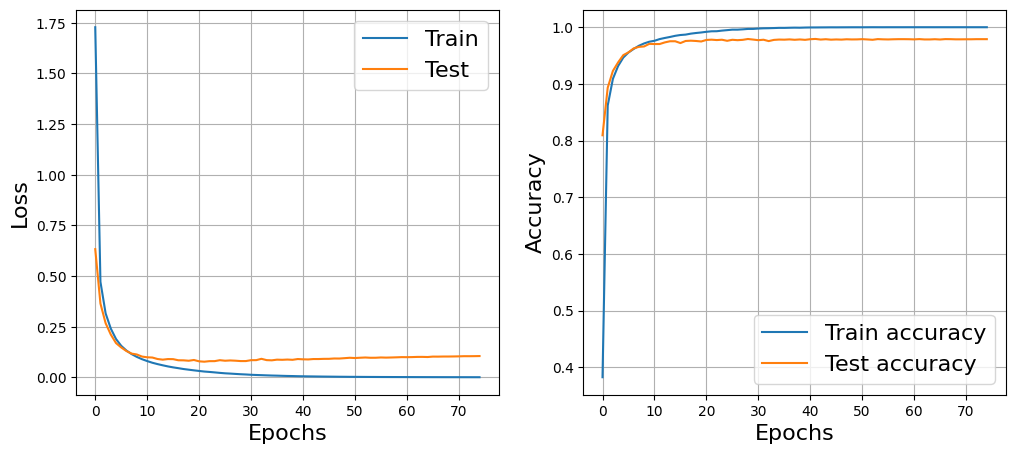

In [75]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 75, 0.01, plot=True, verbose=True)

Epoch 74... (Train/Test) NLL: 0.061/0.102	Accuracy: 0.986/0.970

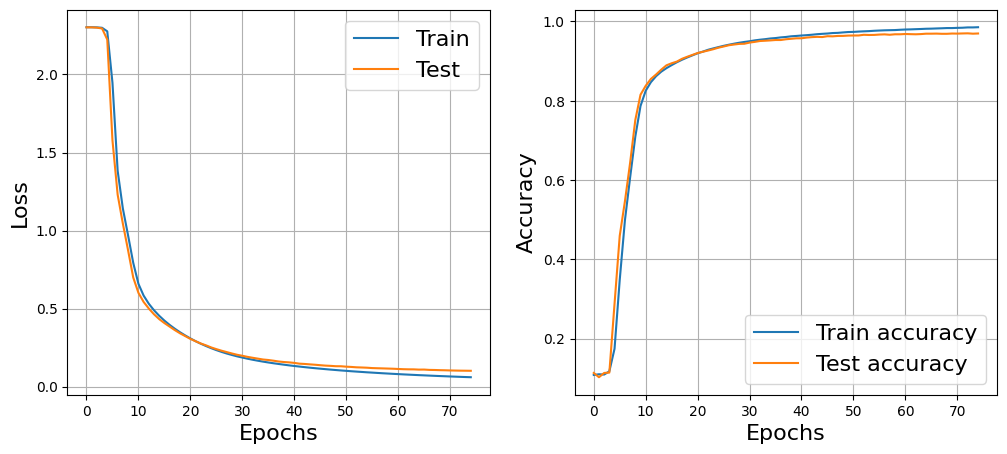

In [79]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 75, 0.01)

Epoch 74... (Train/Test) NLL: 0.002/0.106	Accuracy: 1.000/0.977

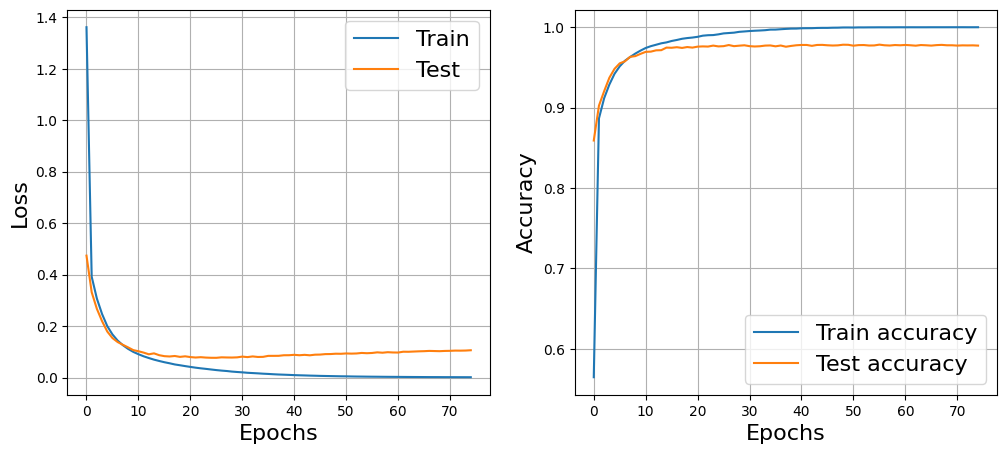

In [80]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 75, 0.01, plot=True, verbose=True)

Epoch 74... (Train/Test) NLL: 0.002/0.086	Accuracy: 1.000/0.978

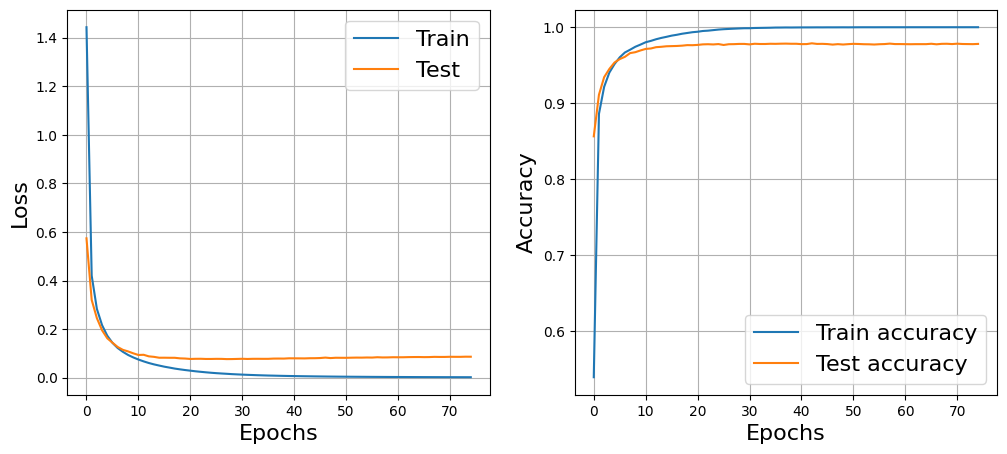

In [81]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 75, 0.01, plot=True, verbose=True)

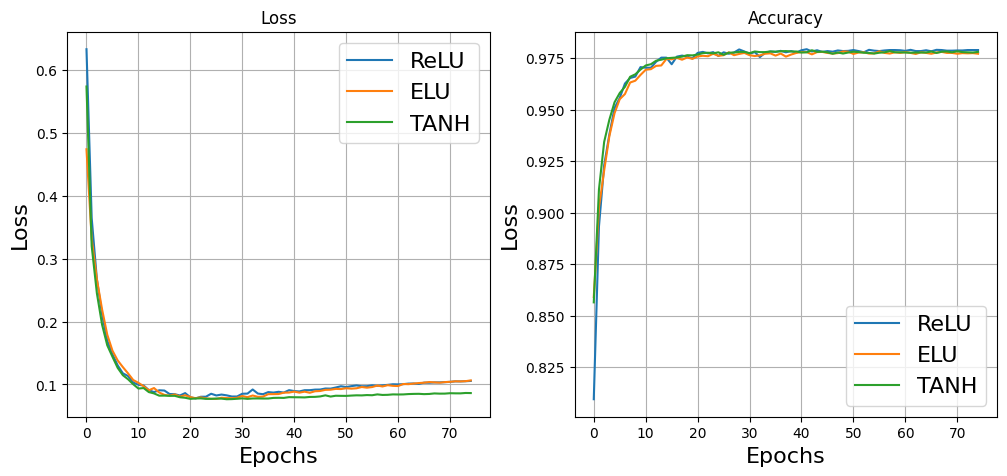

In [82]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
# plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_t, label='TANH')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
# plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_t, label='TANH')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

TANH чуть быстрее сошёлся, чем ELU и ReLU. И по очности на тесте они упёрлись в одинаковое значение.

In [83]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.vstack(wrong_X)
correct_y = np.vstack(correct_y)[:, 0]
predicted_y = np.vstack(predicted_y)[:, 0]
logits = np.vstack(logits)[:, 0]

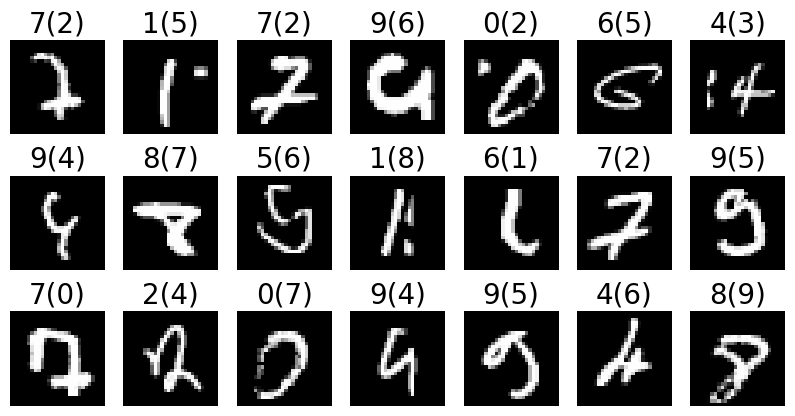

In [84]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

## Задание 2 (4 балла): Аугментации
Необходимо реализовать следующие преобразования (пример можно найти в лекции, также допускается использовать готовые варианты, например "from skimage.transform import rotate")
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности? Какие можно сделать выводы? (Сравнивать подходы можно по аналогии с тем, как это было проделано выше)

In [ ]:
import random
from torch import randn_like, stack
from torchvision.transforms.functional import rotate, affine

def augment_batch(batch, r_prob=0.5, s_prob=0.5, n_prob=0.5):
  augmented_images = []
  for img in batch:
    if random.random() < r_prob:
      img = rotate(img, random.uniform(-15, 15), fill=(-0.424,))
    if random.random() < s_prob:
      img = affine(img, angle=0, translate=(random.uniform(-1, 1) * 10, random.uniform(-0.1, 0.1) * 10), scale=1, shear=0, fill=(-0.424,))
    if random.random() < n_prob:
      img = img + randn_like(img) * 0.05
    augmented_images.append(img)
  return stack(augmented_images)

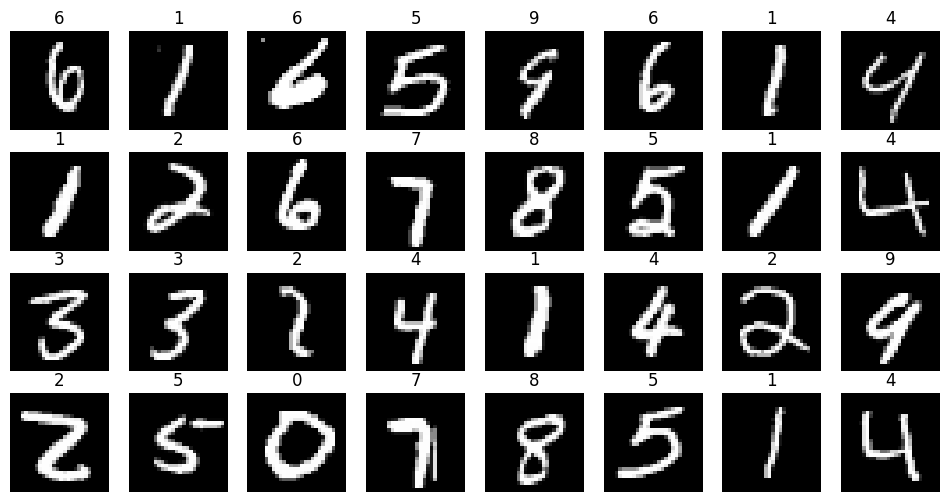

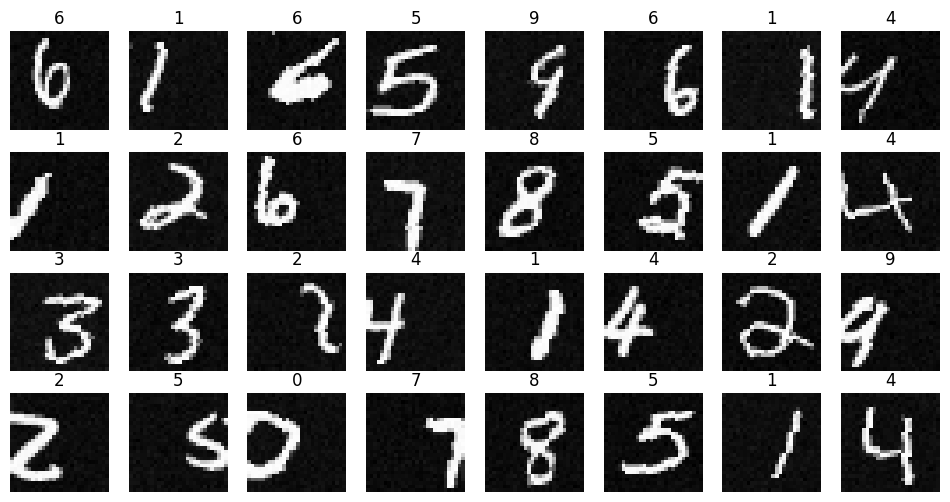

In [110]:
X, y = next(iter(train_loader))
X1 = X.numpy()
X2 = augment_batch(X, r_prob=1, s_prob=1,n_prob=1).numpy()
y = y.numpy()
plt.figure(figsize=(12, 6))
for i in range(len(X1)):
    plt.subplot(4, 8, i+1)
    plt.imshow(X1[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')
plt.figure(figsize=(12, 6))
for i in range(len(X2)):
    plt.subplot(4, 8, i+1)
    plt.imshow(X2[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [111]:
def train_with_aug(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None, r_prob=0, s_prob=0, n_prob=0):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = augment_batch(X, r_prob=r_prob, s_prob=s_prob, n_prob=n_prob).view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

Чтобы увеличить вероятностьпереобучения уменьшил размер батча, за одно значительно уменьшил время схождения к решению.

In [113]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

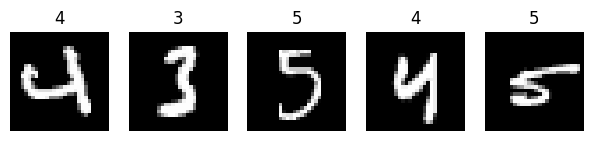

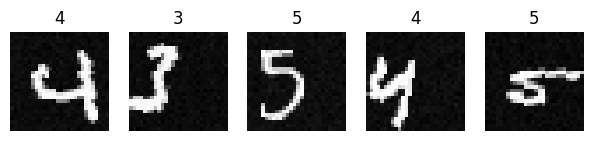

In [114]:
X, y = next(iter(train_loader))
X1 = X.numpy()
X2 = augment_batch(X, r_prob=1, s_prob=1,n_prob=1).numpy()
y = y.numpy()
plt.figure(figsize=(12, 6))
for i in range(len(X1)):
    plt.subplot(4, 8, i+1)
    plt.imshow(X1[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')
plt.figure(figsize=(12, 6))
for i in range(len(X2)):
    plt.subplot(4, 8, i+1)
    plt.imshow(X2[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [112]:
results = {}

Epoch 19... (Train/Test) NLL: 0.000/0.098	Accuracy: 1.000/0.981

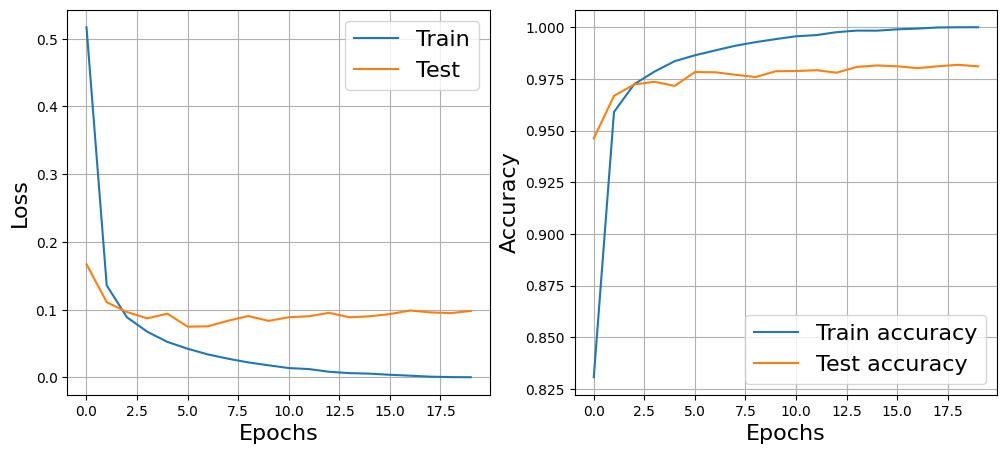

In [118]:
network_no_aug = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
results['no_aug'] = train_with_aug(network_no_aug, 20, 0.01, r_prob=0.0, s_prob=0.0, n_prob=0.0)

Epoch 19... (Train/Test) NLL: 0.030/0.069	Accuracy: 0.991/0.982

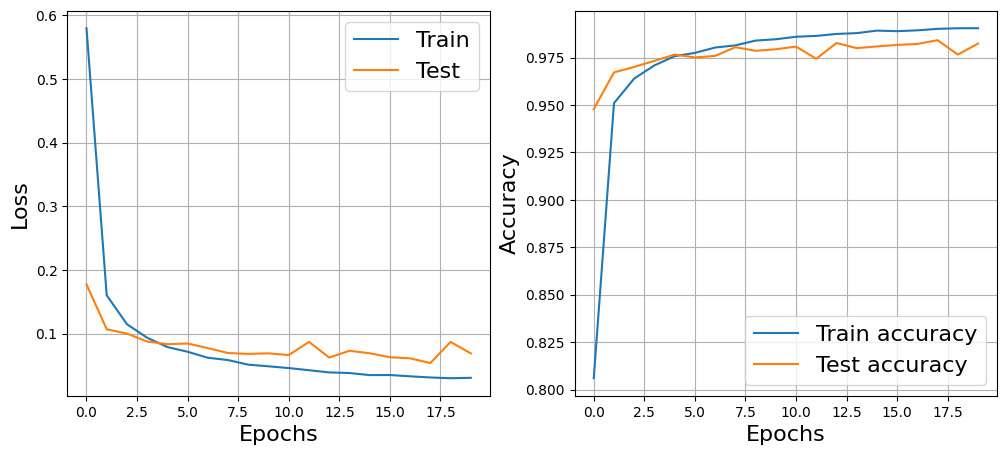

In [119]:
network_rotate = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
results['rotate'] = train_with_aug(network_rotate, 20, 0.01, r_prob=0.5, s_prob=0.0, n_prob=0.0)

Epoch 19... (Train/Test) NLL: 0.090/0.064	Accuracy: 0.972/0.980

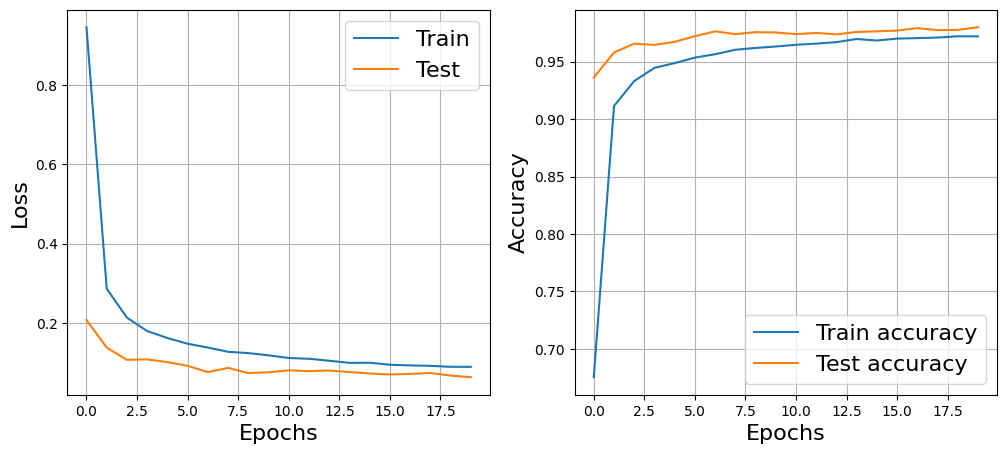

In [120]:
network_shift = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
results['shift'] = train_with_aug(network_shift, 20, 0.01, r_prob=0.0, s_prob=0.5, n_prob=0.0)

Epoch 19... (Train/Test) NLL: 0.001/0.099	Accuracy: 1.000/0.982

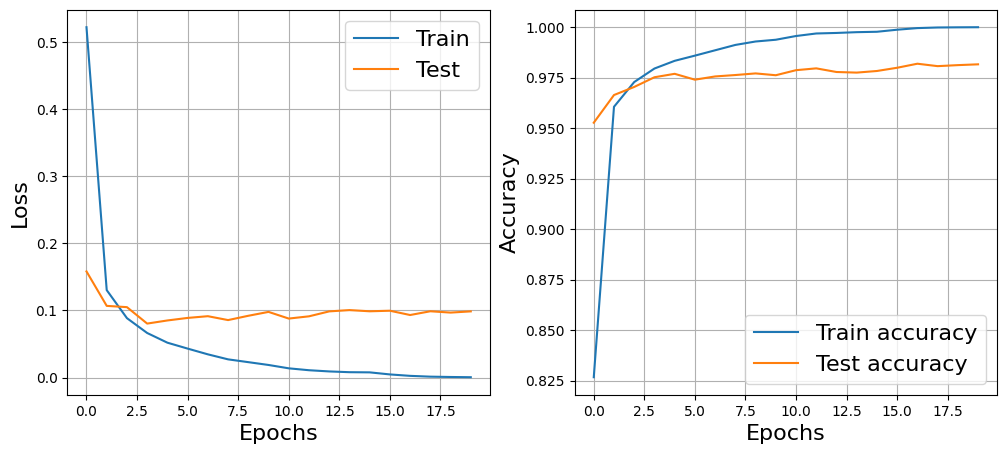

In [121]:
network_shift = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
results['noise'] = train_with_aug(network_shift, 20, 0.01, r_prob=0.0, s_prob=0.0, n_prob=0.5)

Epoch 19... (Train/Test) NLL: 0.110/0.063	Accuracy: 0.966/0.980

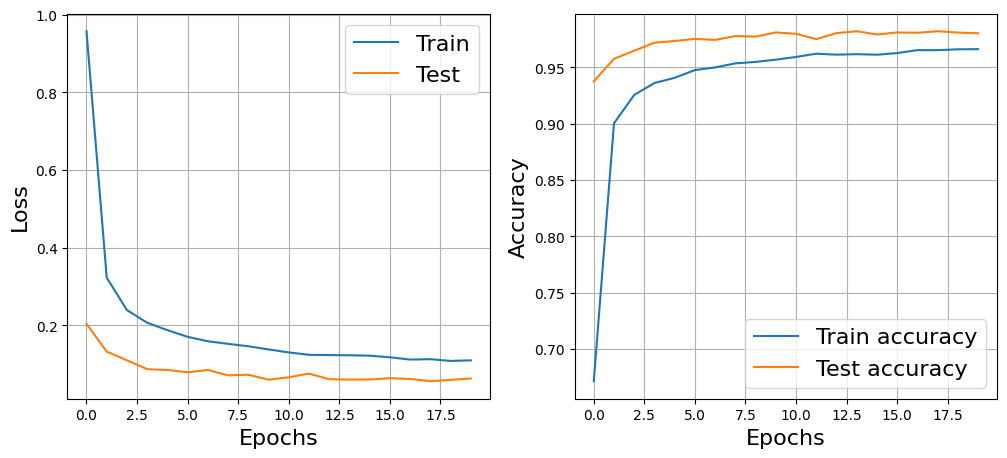

In [122]:
network_shift = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
results['all'] = train_with_aug(network_shift, 20, 0.01, r_prob=0.5, s_prob=0.5, n_prob=0.5)

Все 3 способа аугментации на тестовой выборке упираются в одинаковый с обычным обучением потолок точности 0.982. Так же любые виды аугментации сильно уменьшают скачки в функции потерь. Шум никак не вляяет на схождения к минимуму на тренировочной выборке, поворот незначительно ограничивают схождение и сдвиги значительно значительно влияют на него.